# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

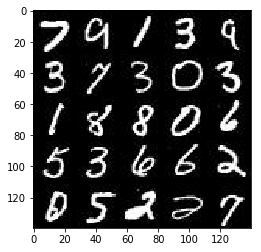

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

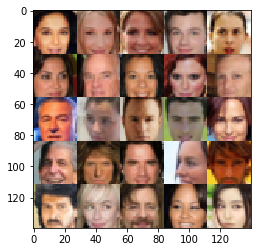

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None,image_width, image_height, image_channels),name='input_real')
    input_z= tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    rate = 0.3
    
    def leaky_relu(x, alpha=0.3, name='leaky_relu'): 
        return tf.maximum(x, alpha * x, name=name)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(
            images, 64, 5, strides=2, padding='same',
            kernel_initializer = tf.contrib.layers.xavier_initializer())
        x1 = tf.layers.dropout(x1, rate)
        relu1 = leaky_relu(x1)
        
        x2 = tf.layers.conv2d(
            relu1, 128, 5, strides=1, padding='same',
            kernel_initializer = tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.dropout(x2, rate)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = leaky_relu(bn2)
        
        x3 = tf.layers.conv2d(
            relu2, 256, 5, strides=2, padding='same',
            kernel_initializer = tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.dropout(x3, rate)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = leaky_relu(bn3)
        
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
    return output, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    alpha = 0.1
    rate = 0.3

    with tf.variable_scope('generator', reuse=reuse):
        z = tf.layers.dropout(z, 0.8)
        # Layer 1
        x1 = tf.layers.dense(z, 7 * 7 * 256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        # Layer 2
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        # Layer 3
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.dropout(x3, 0.8)

        # Output
        logits = tf.layers.conv2d_transpose(
            x3, out_channel_dim, 5, strides=1, padding='SAME')
        output = tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    input_gen = generator(input_z, out_channel_dim)

    d_output_real, d_logit_real = discriminator(input_real)
    d_output_fake, d_logit_fake = discriminator(input_gen, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logit_real, labels=tf.ones_like(d_output_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logit_fake, labels=tf.zeros_like(d_output_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logit_fake, labels=tf.ones_like(d_output_fake)))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    trainable_variables = tf.trainable_variables()
    discriminator_vars = [
        var for var in trainable_variables if var.name.startswith('discriminator')]
    generator_vars = [
        var for var in trainable_variables if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(
            d_loss, var_list=discriminator_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(
            g_loss, var_list=generator_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [ ]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, input_lr = model_inputs(
        data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, input_lr, beta1)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # Resize images ( -1 to 1)
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                feed_dict = {
                    input_real: batch_images,
                    input_z: batch_z,
                    input_lr: learning_rate}
                _ = sess.run(d_opt, feed_dict=feed_dict)
                _ = sess.run(g_opt, feed_dict=feed_dict)
                _ = sess.run(g_opt, feed_dict=feed_dict)
    
                if steps % 10 == 0 or steps == 1:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval(
                        {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
    
                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
    
                if steps % 100 == 0 or steps == 1:
                    show_generator_output(
                        sess, 20, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 36.7139... Generator Loss: 0.0000


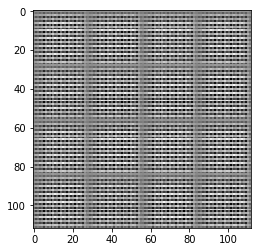

Epoch 1/2... Discriminator Loss: 9.4406... Generator Loss: 0.0016
Epoch 1/2... Discriminator Loss: 4.1026... Generator Loss: 1.3644
Epoch 1/2... Discriminator Loss: 10.0955... Generator Loss: 2.6861
Epoch 1/2... Discriminator Loss: 3.9613... Generator Loss: 0.0596
Epoch 1/2... Discriminator Loss: 2.8785... Generator Loss: 0.1235
Epoch 1/2... Discriminator Loss: 5.6690... Generator Loss: 1.1143
Epoch 1/2... Discriminator Loss: 4.4053... Generator Loss: 2.4559
Epoch 1/2... Discriminator Loss: 4.6611... Generator Loss: 0.0254
Epoch 1/2... Discriminator Loss: 2.2820... Generator Loss: 1.0638
Epoch 1/2... Discriminator Loss: 3.4927... Generator Loss: 0.0417


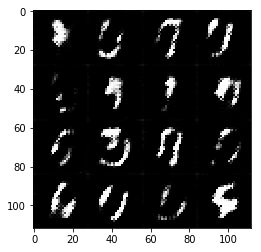

Epoch 1/2... Discriminator Loss: 2.4901... Generator Loss: 1.3082
Epoch 1/2... Discriminator Loss: 2.6741... Generator Loss: 1.6749
Epoch 1/2... Discriminator Loss: 3.8119... Generator Loss: 2.2020
Epoch 1/2... Discriminator Loss: 4.3223... Generator Loss: 1.4056
Epoch 1/2... Discriminator Loss: 4.0442... Generator Loss: 2.3930
Epoch 1/2... Discriminator Loss: 2.1124... Generator Loss: 1.4604
Epoch 1/2... Discriminator Loss: 2.7746... Generator Loss: 3.0842
Epoch 1/2... Discriminator Loss: 3.5733... Generator Loss: 3.3594
Epoch 1/2... Discriminator Loss: 2.2769... Generator Loss: 0.7565
Epoch 1/2... Discriminator Loss: 1.7834... Generator Loss: 0.9565


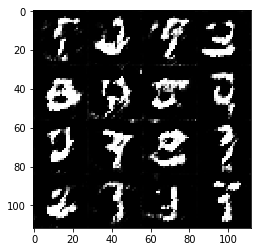

Epoch 1/2... Discriminator Loss: 2.8925... Generator Loss: 0.1035
Epoch 1/2... Discriminator Loss: 2.8122... Generator Loss: 2.1369
Epoch 1/2... Discriminator Loss: 3.5576... Generator Loss: 0.0514
Epoch 1/2... Discriminator Loss: 2.1895... Generator Loss: 0.7042
Epoch 1/2... Discriminator Loss: 2.1251... Generator Loss: 0.4224
Epoch 1/2... Discriminator Loss: 2.2124... Generator Loss: 0.5244
Epoch 1/2... Discriminator Loss: 2.0269... Generator Loss: 0.4872
Epoch 1/2... Discriminator Loss: 2.3293... Generator Loss: 0.2651
Epoch 1/2... Discriminator Loss: 1.9511... Generator Loss: 0.5519
Epoch 1/2... Discriminator Loss: 2.1301... Generator Loss: 0.2565


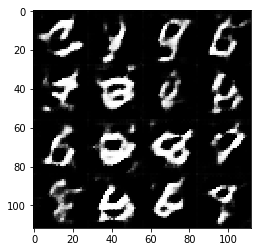

Epoch 1/2... Discriminator Loss: 1.8969... Generator Loss: 0.8872
Epoch 1/2... Discriminator Loss: 2.0860... Generator Loss: 0.2212
Epoch 1/2... Discriminator Loss: 1.7397... Generator Loss: 0.4922
Epoch 1/2... Discriminator Loss: 1.7695... Generator Loss: 0.3355
Epoch 1/2... Discriminator Loss: 1.7943... Generator Loss: 0.4862
Epoch 1/2... Discriminator Loss: 1.7911... Generator Loss: 0.7883
Epoch 1/2... Discriminator Loss: 1.9983... Generator Loss: 1.1344
Epoch 1/2... Discriminator Loss: 1.7093... Generator Loss: 0.9643
Epoch 1/2... Discriminator Loss: 1.7066... Generator Loss: 0.6303
Epoch 1/2... Discriminator Loss: 1.8368... Generator Loss: 0.3085


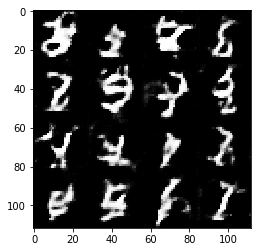

Epoch 1/2... Discriminator Loss: 1.6061... Generator Loss: 0.8719
Epoch 1/2... Discriminator Loss: 1.7216... Generator Loss: 0.7105
Epoch 1/2... Discriminator Loss: 1.9383... Generator Loss: 0.6955
Epoch 1/2... Discriminator Loss: 1.6379... Generator Loss: 0.3808
Epoch 1/2... Discriminator Loss: 2.0739... Generator Loss: 0.2303
Epoch 1/2... Discriminator Loss: 1.4199... Generator Loss: 0.6378
Epoch 1/2... Discriminator Loss: 1.6167... Generator Loss: 0.8561
Epoch 1/2... Discriminator Loss: 1.7612... Generator Loss: 0.5173
Epoch 1/2... Discriminator Loss: 1.6401... Generator Loss: 0.5565
Epoch 1/2... Discriminator Loss: 1.5908... Generator Loss: 0.8248


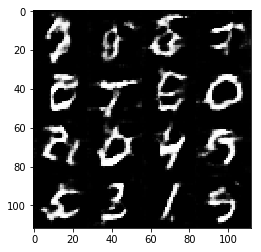

Epoch 1/2... Discriminator Loss: 1.8082... Generator Loss: 0.7486
Epoch 1/2... Discriminator Loss: 1.6690... Generator Loss: 0.6816
Epoch 1/2... Discriminator Loss: 1.7251... Generator Loss: 0.9210
Epoch 1/2... Discriminator Loss: 1.7315... Generator Loss: 0.7521
Epoch 1/2... Discriminator Loss: 1.9305... Generator Loss: 0.5621
Epoch 1/2... Discriminator Loss: 1.6706... Generator Loss: 0.4115
Epoch 1/2... Discriminator Loss: 1.8033... Generator Loss: 0.3130
Epoch 1/2... Discriminator Loss: 1.6160... Generator Loss: 0.3885
Epoch 1/2... Discriminator Loss: 1.8825... Generator Loss: 0.9590
Epoch 1/2... Discriminator Loss: 1.7376... Generator Loss: 0.7615


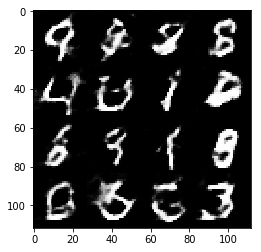

Epoch 1/2... Discriminator Loss: 1.5806... Generator Loss: 0.5839
Epoch 1/2... Discriminator Loss: 1.6150... Generator Loss: 0.5295
Epoch 1/2... Discriminator Loss: 1.7334... Generator Loss: 0.7689
Epoch 1/2... Discriminator Loss: 1.7013... Generator Loss: 0.6961
Epoch 1/2... Discriminator Loss: 1.5842... Generator Loss: 0.5108
Epoch 1/2... Discriminator Loss: 1.6467... Generator Loss: 0.3666
Epoch 1/2... Discriminator Loss: 1.6122... Generator Loss: 0.6926
Epoch 1/2... Discriminator Loss: 1.6620... Generator Loss: 0.3345
Epoch 1/2... Discriminator Loss: 1.8574... Generator Loss: 0.3152
Epoch 1/2... Discriminator Loss: 2.0612... Generator Loss: 0.2093


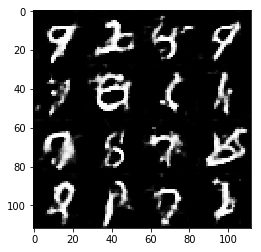

Epoch 1/2... Discriminator Loss: 1.9165... Generator Loss: 0.3119
Epoch 1/2... Discriminator Loss: 1.7597... Generator Loss: 0.3750
Epoch 1/2... Discriminator Loss: 1.6690... Generator Loss: 0.4213
Epoch 1/2... Discriminator Loss: 1.6192... Generator Loss: 0.4690
Epoch 1/2... Discriminator Loss: 1.5035... Generator Loss: 0.6476
Epoch 1/2... Discriminator Loss: 1.6648... Generator Loss: 0.9229
Epoch 1/2... Discriminator Loss: 1.6440... Generator Loss: 0.5564
Epoch 1/2... Discriminator Loss: 1.6265... Generator Loss: 0.7623
Epoch 1/2... Discriminator Loss: 1.5244... Generator Loss: 0.6445
Epoch 1/2... Discriminator Loss: 1.5621... Generator Loss: 0.7978


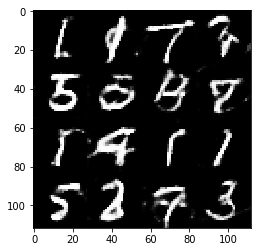

Epoch 1/2... Discriminator Loss: 1.6060... Generator Loss: 0.6770
Epoch 1/2... Discriminator Loss: 1.5629... Generator Loss: 0.5463
Epoch 1/2... Discriminator Loss: 1.6102... Generator Loss: 0.6868
Epoch 1/2... Discriminator Loss: 1.8703... Generator Loss: 0.9842
Epoch 1/2... Discriminator Loss: 1.6286... Generator Loss: 0.8398
Epoch 1/2... Discriminator Loss: 1.5251... Generator Loss: 0.7037
Epoch 1/2... Discriminator Loss: 1.6254... Generator Loss: 0.5840
Epoch 1/2... Discriminator Loss: 1.7081... Generator Loss: 0.6864
Epoch 1/2... Discriminator Loss: 1.6056... Generator Loss: 0.7003
Epoch 1/2... Discriminator Loss: 1.5258... Generator Loss: 0.5126


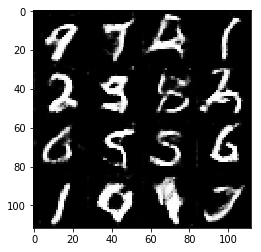

Epoch 1/2... Discriminator Loss: 1.5584... Generator Loss: 0.4357
Epoch 1/2... Discriminator Loss: 2.0212... Generator Loss: 0.2088
Epoch 1/2... Discriminator Loss: 1.4698... Generator Loss: 0.5601
Epoch 2/2... Discriminator Loss: 1.6769... Generator Loss: 0.9304
Epoch 2/2... Discriminator Loss: 1.6164... Generator Loss: 0.7263
Epoch 2/2... Discriminator Loss: 1.4484... Generator Loss: 0.7733
Epoch 2/2... Discriminator Loss: 1.4712... Generator Loss: 0.7257
Epoch 2/2... Discriminator Loss: 1.5162... Generator Loss: 0.5230
Epoch 2/2... Discriminator Loss: 1.6182... Generator Loss: 0.4242
Epoch 2/2... Discriminator Loss: 1.7568... Generator Loss: 0.3169


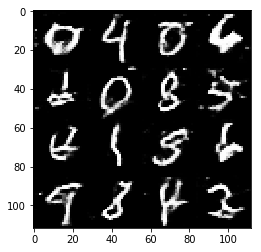

Epoch 2/2... Discriminator Loss: 1.6761... Generator Loss: 0.5312
Epoch 2/2... Discriminator Loss: 1.7219... Generator Loss: 0.3781
Epoch 2/2... Discriminator Loss: 1.5782... Generator Loss: 0.4432
Epoch 2/2... Discriminator Loss: 1.7253... Generator Loss: 0.3420
Epoch 2/2... Discriminator Loss: 1.7703... Generator Loss: 0.3438
Epoch 2/2... Discriminator Loss: 1.4846... Generator Loss: 0.5301
Epoch 2/2... Discriminator Loss: 1.6536... Generator Loss: 0.3637
Epoch 2/2... Discriminator Loss: 1.7465... Generator Loss: 0.3703
Epoch 2/2... Discriminator Loss: 2.0092... Generator Loss: 1.1077
Epoch 2/2... Discriminator Loss: 1.6352... Generator Loss: 0.5618


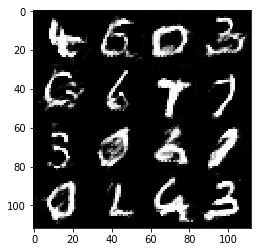

Epoch 2/2... Discriminator Loss: 1.6227... Generator Loss: 0.3900
Epoch 2/2... Discriminator Loss: 1.5783... Generator Loss: 0.7245
Epoch 2/2... Discriminator Loss: 1.5062... Generator Loss: 0.6583
Epoch 2/2... Discriminator Loss: 1.5047... Generator Loss: 0.8209
Epoch 2/2... Discriminator Loss: 1.5908... Generator Loss: 0.6513
Epoch 2/2... Discriminator Loss: 1.8346... Generator Loss: 1.2505
Epoch 2/2... Discriminator Loss: 1.5615... Generator Loss: 0.5496
Epoch 2/2... Discriminator Loss: 1.6767... Generator Loss: 0.8238
Epoch 2/2... Discriminator Loss: 1.4415... Generator Loss: 0.4875
Epoch 2/2... Discriminator Loss: 1.9424... Generator Loss: 0.2008


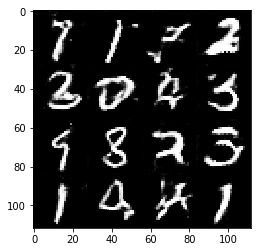

Epoch 2/2... Discriminator Loss: 1.5866... Generator Loss: 0.3681
Epoch 2/2... Discriminator Loss: 1.4674... Generator Loss: 0.4606
Epoch 2/2... Discriminator Loss: 1.7491... Generator Loss: 0.3186
Epoch 2/2... Discriminator Loss: 1.6497... Generator Loss: 0.3927
Epoch 2/2... Discriminator Loss: 1.4698... Generator Loss: 0.4813
Epoch 2/2... Discriminator Loss: 1.5494... Generator Loss: 0.7183
Epoch 2/2... Discriminator Loss: 1.8065... Generator Loss: 0.2815
Epoch 2/2... Discriminator Loss: 1.5455... Generator Loss: 0.4812
Epoch 2/2... Discriminator Loss: 1.7900... Generator Loss: 0.3193
Epoch 2/2... Discriminator Loss: 1.4924... Generator Loss: 0.5483


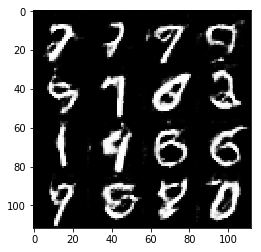

Epoch 2/2... Discriminator Loss: 1.4060... Generator Loss: 0.6167
Epoch 2/2... Discriminator Loss: 1.5174... Generator Loss: 0.4736
Epoch 2/2... Discriminator Loss: 1.6583... Generator Loss: 0.3900
Epoch 2/2... Discriminator Loss: 1.6409... Generator Loss: 0.6166
Epoch 2/2... Discriminator Loss: 1.6004... Generator Loss: 0.3962
Epoch 2/2... Discriminator Loss: 1.6874... Generator Loss: 0.3086
Epoch 2/2... Discriminator Loss: 1.6483... Generator Loss: 0.4432
Epoch 2/2... Discriminator Loss: 1.5430... Generator Loss: 0.4715
Epoch 2/2... Discriminator Loss: 1.5142... Generator Loss: 0.5012
Epoch 2/2... Discriminator Loss: 1.7075... Generator Loss: 0.3085


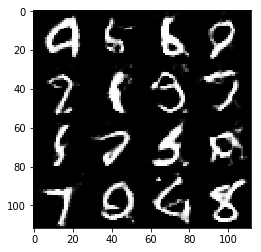

Epoch 2/2... Discriminator Loss: 1.6553... Generator Loss: 0.3681
Epoch 2/2... Discriminator Loss: 1.5931... Generator Loss: 0.3619
Epoch 2/2... Discriminator Loss: 1.5084... Generator Loss: 0.5492
Epoch 2/2... Discriminator Loss: 1.8361... Generator Loss: 0.2964
Epoch 2/2... Discriminator Loss: 1.5776... Generator Loss: 0.4376
Epoch 2/2... Discriminator Loss: 1.6001... Generator Loss: 0.3508
Epoch 2/2... Discriminator Loss: 1.4567... Generator Loss: 0.6338
Epoch 2/2... Discriminator Loss: 1.7762... Generator Loss: 0.9957
Epoch 2/2... Discriminator Loss: 1.6415... Generator Loss: 0.4992
Epoch 2/2... Discriminator Loss: 1.7245... Generator Loss: 0.3130


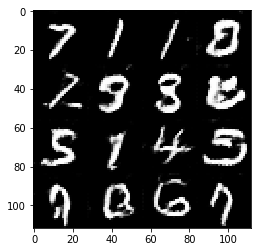

Epoch 2/2... Discriminator Loss: 1.8868... Generator Loss: 0.2442
Epoch 2/2... Discriminator Loss: 1.5514... Generator Loss: 0.4331
Epoch 2/2... Discriminator Loss: 1.7053... Generator Loss: 1.1133
Epoch 2/2... Discriminator Loss: 1.4389... Generator Loss: 0.5789
Epoch 2/2... Discriminator Loss: 1.5322... Generator Loss: 0.4532
Epoch 2/2... Discriminator Loss: 1.5125... Generator Loss: 0.4845
Epoch 2/2... Discriminator Loss: 1.4922... Generator Loss: 0.5406
Epoch 2/2... Discriminator Loss: 1.6735... Generator Loss: 0.8533
Epoch 2/2... Discriminator Loss: 1.5669... Generator Loss: 0.3749
Epoch 2/2... Discriminator Loss: 1.7467... Generator Loss: 0.2758


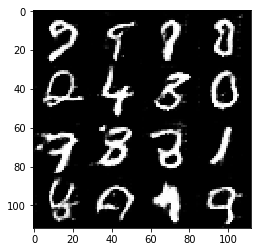

Epoch 2/2... Discriminator Loss: 1.4218... Generator Loss: 0.5336
Epoch 2/2... Discriminator Loss: 1.6177... Generator Loss: 1.1326
Epoch 2/2... Discriminator Loss: 1.4292... Generator Loss: 0.5575
Epoch 2/2... Discriminator Loss: 1.4996... Generator Loss: 0.6342
Epoch 2/2... Discriminator Loss: 1.5043... Generator Loss: 0.4698
Epoch 2/2... Discriminator Loss: 1.4810... Generator Loss: 0.4204
Epoch 2/2... Discriminator Loss: 1.3011... Generator Loss: 0.7847
Epoch 2/2... Discriminator Loss: 1.5054... Generator Loss: 0.6258
Epoch 2/2... Discriminator Loss: 1.5162... Generator Loss: 0.9078
Epoch 2/2... Discriminator Loss: 1.7960... Generator Loss: 0.2657


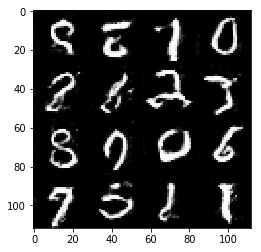

Epoch 2/2... Discriminator Loss: 1.5254... Generator Loss: 0.4844
Epoch 2/2... Discriminator Loss: 1.3954... Generator Loss: 0.6112
Epoch 2/2... Discriminator Loss: 1.6238... Generator Loss: 0.8141
Epoch 2/2... Discriminator Loss: 1.6230... Generator Loss: 0.9329
Epoch 2/2... Discriminator Loss: 1.4999... Generator Loss: 0.6297
Epoch 2/2... Discriminator Loss: 1.6692... Generator Loss: 0.3623
Epoch 2/2... Discriminator Loss: 1.4861... Generator Loss: 0.7945
Epoch 2/2... Discriminator Loss: 1.5081... Generator Loss: 0.8226
Epoch 2/2... Discriminator Loss: 1.4625... Generator Loss: 0.7562
Epoch 2/2... Discriminator Loss: 1.3394... Generator Loss: 0.7675


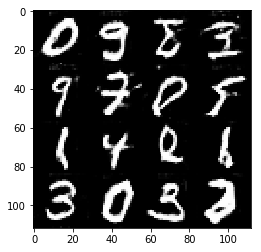

Epoch 2/2... Discriminator Loss: 1.5069... Generator Loss: 0.5974
Epoch 2/2... Discriminator Loss: 1.4802... Generator Loss: 0.6199
Epoch 2/2... Discriminator Loss: 1.9096... Generator Loss: 0.2259
Epoch 2/2... Discriminator Loss: 1.5007... Generator Loss: 0.6295
Epoch 2/2... Discriminator Loss: 1.7521... Generator Loss: 0.2661
Epoch 2/2... Discriminator Loss: 1.4844... Generator Loss: 0.5944
Epoch 2/2... Discriminator Loss: 1.5017... Generator Loss: 0.6024


In [ ]:
batch_size = 64
z_dim = 128
learning_rate = 0.003
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 9.1232... Generator Loss: 0.0002


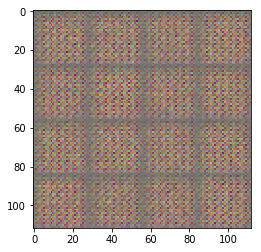

Epoch 1/1... Discriminator Loss: 6.4612... Generator Loss: 0.0044
Epoch 1/1... Discriminator Loss: 4.1781... Generator Loss: 0.0222
Epoch 1/1... Discriminator Loss: 3.0947... Generator Loss: 0.0685
Epoch 1/1... Discriminator Loss: 2.9524... Generator Loss: 0.0955
Epoch 1/1... Discriminator Loss: 2.9608... Generator Loss: 0.0889
Epoch 1/1... Discriminator Loss: 1.9512... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 1.5096... Generator Loss: 1.3078
Epoch 1/1... Discriminator Loss: 2.3042... Generator Loss: 2.0218
Epoch 1/1... Discriminator Loss: 1.2414... Generator Loss: 1.2983
Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 1.6406


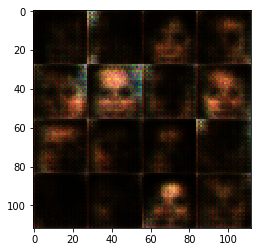

Epoch 1/1... Discriminator Loss: 1.5449... Generator Loss: 0.8848
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 1.1070
Epoch 1/1... Discriminator Loss: 1.7458... Generator Loss: 0.3305
Epoch 1/1... Discriminator Loss: 1.8538... Generator Loss: 0.3131
Epoch 1/1... Discriminator Loss: 2.0995... Generator Loss: 0.2083
Epoch 1/1... Discriminator Loss: 1.6443... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.7027... Generator Loss: 0.8428
Epoch 1/1... Discriminator Loss: 1.9681... Generator Loss: 1.2127
Epoch 1/1... Discriminator Loss: 1.7644... Generator Loss: 0.3835


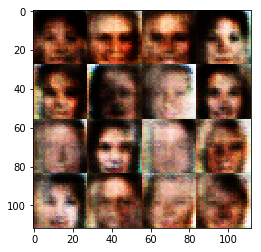

Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.9394
Epoch 1/1... Discriminator Loss: 1.8548... Generator Loss: 0.9858
Epoch 1/1... Discriminator Loss: 1.6128... Generator Loss: 0.5067
Epoch 1/1... Discriminator Loss: 1.5093... Generator Loss: 0.5166
Epoch 1/1... Discriminator Loss: 1.8762... Generator Loss: 0.3560
Epoch 1/1... Discriminator Loss: 1.6880... Generator Loss: 0.4635
Epoch 1/1... Discriminator Loss: 1.7038... Generator Loss: 0.5330
Epoch 1/1... Discriminator Loss: 1.6780... Generator Loss: 0.6122
Epoch 1/1... Discriminator Loss: 1.5648... Generator Loss: 0.5703
Epoch 1/1... Discriminator Loss: 1.5763... Generator Loss: 0.5381


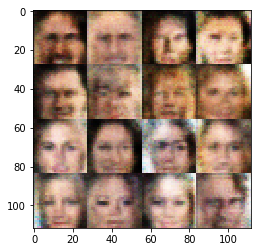

Epoch 1/1... Discriminator Loss: 1.4961... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.5254... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.5858... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.6491... Generator Loss: 0.6083
Epoch 1/1... Discriminator Loss: 1.5444... Generator Loss: 0.5671
Epoch 1/1... Discriminator Loss: 1.5146... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.5986... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.7032... Generator Loss: 0.5472
Epoch 1/1... Discriminator Loss: 1.5678... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.5601... Generator Loss: 0.7327


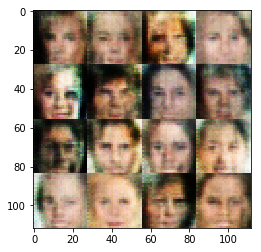

Epoch 1/1... Discriminator Loss: 1.6238... Generator Loss: 0.5305
Epoch 1/1... Discriminator Loss: 1.5836... Generator Loss: 0.4974
Epoch 1/1... Discriminator Loss: 1.6896... Generator Loss: 0.5287
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.4999... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.7041... Generator Loss: 0.8621
Epoch 1/1... Discriminator Loss: 1.5481... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.5975... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.6623... Generator Loss: 0.6581


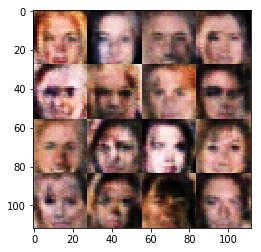

Epoch 1/1... Discriminator Loss: 1.5118... Generator Loss: 0.6132
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.5378... Generator Loss: 0.5423
Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 1.5169... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.6268... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.5646... Generator Loss: 0.5714
Epoch 1/1... Discriminator Loss: 1.7254... Generator Loss: 0.5699
Epoch 1/1... Discriminator Loss: 1.7010... Generator Loss: 0.6407


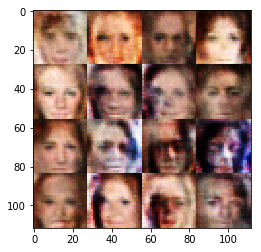

Epoch 1/1... Discriminator Loss: 1.6371... Generator Loss: 0.5362
Epoch 1/1... Discriminator Loss: 1.6152... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 1.6738... Generator Loss: 0.5856
Epoch 1/1... Discriminator Loss: 1.5714... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.7813... Generator Loss: 0.3837
Epoch 1/1... Discriminator Loss: 1.5442... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.6865... Generator Loss: 0.3965
Epoch 1/1... Discriminator Loss: 1.6147... Generator Loss: 0.5209
Epoch 1/1... Discriminator Loss: 1.5825... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.5213... Generator Loss: 0.7054


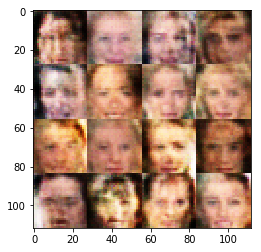

Epoch 1/1... Discriminator Loss: 1.6350... Generator Loss: 0.6151
Epoch 1/1... Discriminator Loss: 1.6143... Generator Loss: 0.4599
Epoch 1/1... Discriminator Loss: 1.6104... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 1.5859... Generator Loss: 0.5358
Epoch 1/1... Discriminator Loss: 1.6613... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.6328... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.6346... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.6170... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.6010... Generator Loss: 0.5279


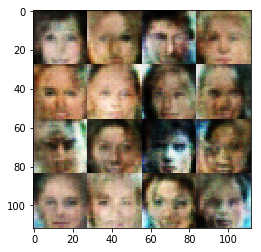

Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.4998... Generator Loss: 0.6024
Epoch 1/1... Discriminator Loss: 1.4909... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 1.6337... Generator Loss: 0.5880
Epoch 1/1... Discriminator Loss: 1.5164... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.5860... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 1.5645... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.6074... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.5605... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.6925


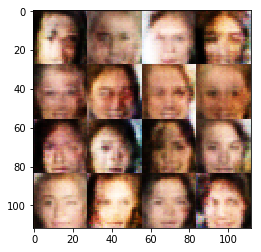

Epoch 1/1... Discriminator Loss: 1.5855... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.5186... Generator Loss: 0.8785
Epoch 1/1... Discriminator Loss: 1.6972... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.5279
Epoch 1/1... Discriminator Loss: 1.5793... Generator Loss: 0.5275
Epoch 1/1... Discriminator Loss: 1.6616... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.6086... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 1.5373... Generator Loss: 0.6276


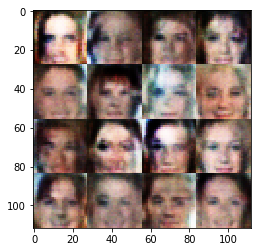

Epoch 1/1... Discriminator Loss: 1.5078... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.4957... Generator Loss: 0.5144
Epoch 1/1... Discriminator Loss: 1.5851... Generator Loss: 0.4785
Epoch 1/1... Discriminator Loss: 1.5140... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 1.5065... Generator Loss: 0.5897
Epoch 1/1... Discriminator Loss: 1.5047... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.6069... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.5275
Epoch 1/1... Discriminator Loss: 1.5415... Generator Loss: 0.6874


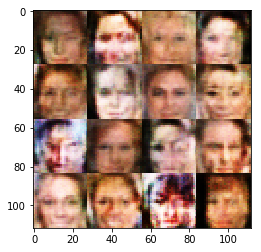

Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.5415
Epoch 1/1... Discriminator Loss: 1.5168... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 1.5335... Generator Loss: 0.8943
Epoch 1/1... Discriminator Loss: 1.6653... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.6324... Generator Loss: 0.3781
Epoch 1/1... Discriminator Loss: 1.5943... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.5600... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.5442... Generator Loss: 0.6925


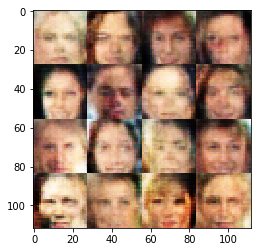

Epoch 1/1... Discriminator Loss: 1.5876... Generator Loss: 0.4325
Epoch 1/1... Discriminator Loss: 1.5658... Generator Loss: 0.4801
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 1.5396... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.5753... Generator Loss: 0.4987
Epoch 1/1... Discriminator Loss: 1.4601... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.5233... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.5653... Generator Loss: 0.5286
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 0.5766


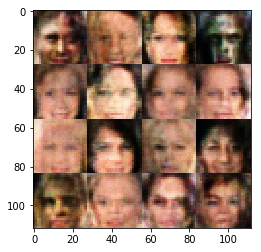

Epoch 1/1... Discriminator Loss: 1.5043... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.5795... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.5154... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 1.5589... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.6604... Generator Loss: 0.5202
Epoch 1/1... Discriminator Loss: 1.5451... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 0.6018


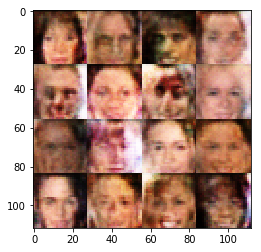

Epoch 1/1... Discriminator Loss: 1.5460... Generator Loss: 0.5401
Epoch 1/1... Discriminator Loss: 1.5666... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.5570... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.5300... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.4970... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.5710
Epoch 1/1... Discriminator Loss: 1.5182... Generator Loss: 0.5569
Epoch 1/1... Discriminator Loss: 1.5205... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.5217... Generator Loss: 0.6090


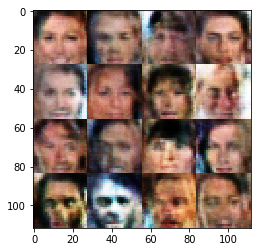

Epoch 1/1... Discriminator Loss: 1.5429... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.5555... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.5214
Epoch 1/1... Discriminator Loss: 1.5349... Generator Loss: 0.5703
Epoch 1/1... Discriminator Loss: 1.5059... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.5121... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 1.5852... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.6142... Generator Loss: 0.6626


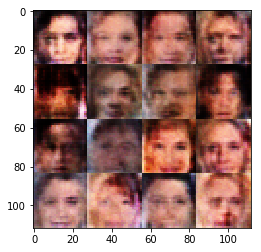

Epoch 1/1... Discriminator Loss: 1.5519... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.5281... Generator Loss: 0.5970
Epoch 1/1... Discriminator Loss: 1.5394... Generator Loss: 0.5186
Epoch 1/1... Discriminator Loss: 1.7549... Generator Loss: 0.4040
Epoch 1/1... Discriminator Loss: 1.5249... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.6289... Generator Loss: 0.5358
Epoch 1/1... Discriminator Loss: 1.5485... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 1.5617... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 1.5424... Generator Loss: 0.5909
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.7715


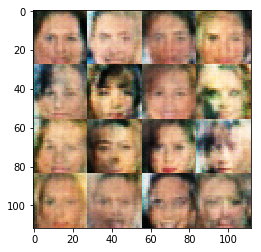

Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.6047
Epoch 1/1... Discriminator Loss: 1.5104... Generator Loss: 0.5049
Epoch 1/1... Discriminator Loss: 1.5142... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.5435... Generator Loss: 0.5730
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.5726... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.5179... Generator Loss: 0.5276
Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.6698


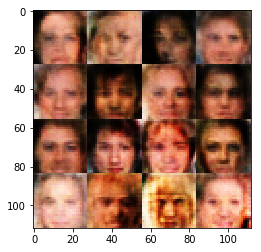

Epoch 1/1... Discriminator Loss: 1.5230... Generator Loss: 0.6004
Epoch 1/1... Discriminator Loss: 1.4974... Generator Loss: 0.5713
Epoch 1/1... Discriminator Loss: 1.4875... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 0.4759
Epoch 1/1... Discriminator Loss: 1.5561... Generator Loss: 0.5863
Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 0.5632
Epoch 1/1... Discriminator Loss: 1.5472... Generator Loss: 0.5990
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.5084... Generator Loss: 0.5066


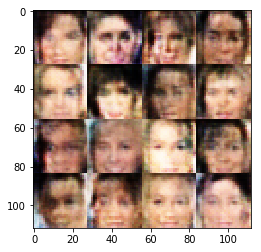

Epoch 1/1... Discriminator Loss: 1.6562... Generator Loss: 0.5353
Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.6784
Epoch 1/1... Discriminator Loss: 1.5571... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.5487... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 1.4777... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 1.5058... Generator Loss: 0.6184
Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.5626
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.5270


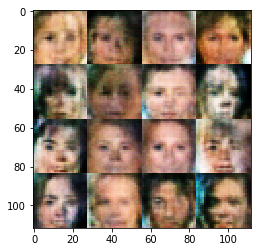

Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.9423
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.5713... Generator Loss: 0.5622
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.5397... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.5458
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.6162


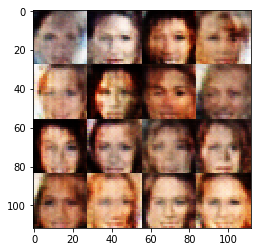

Epoch 1/1... Discriminator Loss: 1.5025... Generator Loss: 0.5392
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.5840
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.4832... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 0.7259
Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.4808... Generator Loss: 0.6406


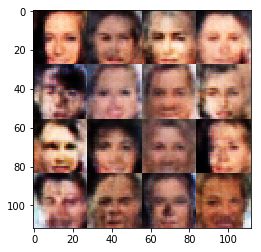

Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 0.5645
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 1.5808... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.5517... Generator Loss: 0.4927
Epoch 1/1... Discriminator Loss: 1.5835... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.5168... Generator Loss: 0.6115


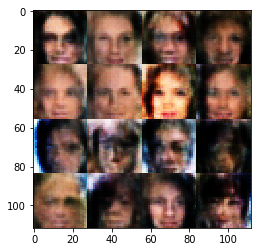

Epoch 1/1... Discriminator Loss: 1.6194... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.5099... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.5179... Generator Loss: 0.5753
Epoch 1/1... Discriminator Loss: 1.5374... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 1.4953... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.6940... Generator Loss: 0.3887
Epoch 1/1... Discriminator Loss: 1.5226... Generator Loss: 0.5085
Epoch 1/1... Discriminator Loss: 1.5856... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.6960


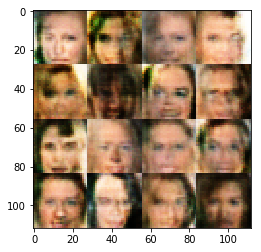

Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 0.6024
Epoch 1/1... Discriminator Loss: 1.5006... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.5021... Generator Loss: 0.5493
Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.5926
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.5687... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.5844... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.5248... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.5421... Generator Loss: 0.7374


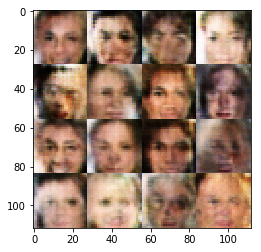

Epoch 1/1... Discriminator Loss: 1.5747... Generator Loss: 0.5662
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.5247... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 1.5190... Generator Loss: 0.5698
Epoch 1/1... Discriminator Loss: 1.5393... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.5762... Generator Loss: 0.6039
Epoch 1/1... Discriminator Loss: 1.5177... Generator Loss: 0.5272


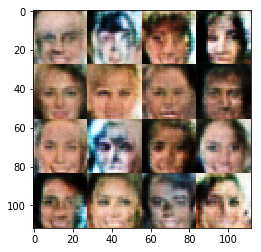

Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.4765... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.5934... Generator Loss: 0.4648
Epoch 1/1... Discriminator Loss: 1.6477... Generator Loss: 0.5181
Epoch 1/1... Discriminator Loss: 1.4942... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 1.6240... Generator Loss: 0.6153
Epoch 1/1... Discriminator Loss: 1.4965... Generator Loss: 0.5657
Epoch 1/1... Discriminator Loss: 1.5391... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.4874... Generator Loss: 0.6548


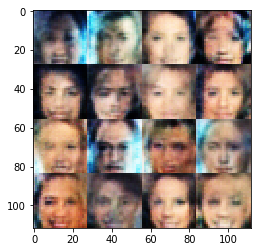

Epoch 1/1... Discriminator Loss: 1.5308... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.5391... Generator Loss: 0.5422
Epoch 1/1... Discriminator Loss: 1.4984... Generator Loss: 0.5544
Epoch 1/1... Discriminator Loss: 1.5317... Generator Loss: 0.5948
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.5860
Epoch 1/1... Discriminator Loss: 1.5275... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.5348
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.7587


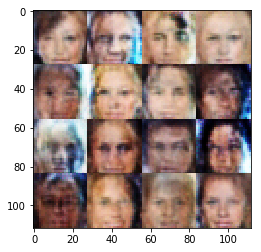

Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.5341
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.6332
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.5511
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 0.5602
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.5712
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 1.5153... Generator Loss: 0.5910
Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 0.6727


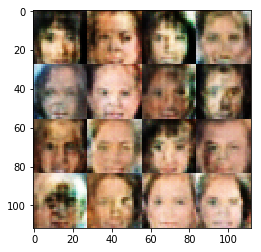

Epoch 1/1... Discriminator Loss: 1.5138... Generator Loss: 0.5656
Epoch 1/1... Discriminator Loss: 1.6059... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.5871
Epoch 1/1... Discriminator Loss: 1.5032... Generator Loss: 0.5904
Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.6285


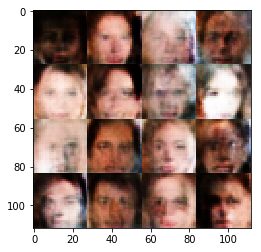

Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.6231
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.6438
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.5339


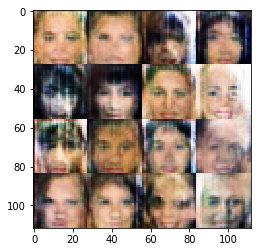

Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.6153
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.5568... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.6516


In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.